# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [52]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.3.0


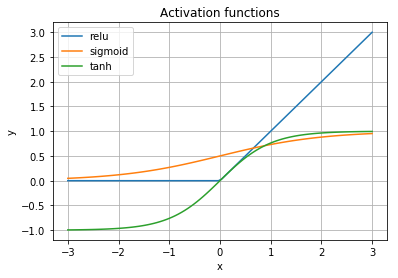

In [53]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [54]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    import os
    import numpy as np
    all_batches = []
    all_labels = []
    cifar10_dir = "data/cifar-10-batches-py"
    for b in range(1,6):
        f_train_curr = os.path.join(cifar10_dir, 'data_batch_%d' % (b, ))
        data, labels = unpickle(f_train_curr)
        batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(labels)
        all_batches.append(batch)
        all_labels.append(labels)
    data = np.concatenate(all_batches)
    labels_t = np.concatenate(all_labels)
    del batch, labels
    val_data = data[range(num_training, num_training+num_validation)]
    val_labels = labels_t[range(num_training, num_training+num_validation)]
    data_train = data[range(0,num_training)]
    labels_train = labels_t[range(0,num_training)]
    return data_train, labels_train, val_data, val_labels

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    import os
    import numpy as np
    cifar10_dir = "data/cifar-10-batches-py"
    f_test_curr = os.path.join(cifar10_dir, 'test_batch')
    data, labels = unpickle(f_test_curr)
    batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels = np.array(labels)
    return batch, labels
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [55]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def fully_conn(input, output_unit, regularizer=None,activation = None):
    return tf.contrib.layers.fully_connected(inputs=input,  num_outputs = output_unit, activation_fn=activation
                                             ,weights_regularizer= regularizer)

def flatten(inputs,outputs_collections=None,scope=None):
    return tf.contrib.layers.flatten(inputs)


def normalize(input, dim, isTraining):
    with tf.variable_scope('batchNormal'):
        beta = tf.Variable(tf.constant(0.0, shape=[dim]),trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[dim]),trainable=True)
        mean_b, var_b = tf.nn.moments(input, [0,1,2])
        e = tf.train.ExponentialMovingAverage(decay=0.5)
        def update():
            e_app = e.apply([mean_b, var_b])
            with tf.control_dependencies([e_app]):
                return tf.identity(mean_b), tf.identity(var_b)
        mean, var = tf.cond(isTraining, update, lambda: (e.average(mean_b), e.average(var_b)))        
    return tf.nn.batch_normalization(input, mean, var, beta, gamma, 1e-3)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [58]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)              
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_conn(self.flat,384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_conn(self.relu3,10)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.int32,None)
        self.keep_prob = tf.placeholder(tf.float32,None)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        g_step = tf.Variable(0, trainable=False)
        learning_rate_initial = 5e-4
        learning_rate = tf.train.exponential_decay(learning_rate_initial, g_step,
                                           500, 0.96, staircase=True)
        
        self.train_op = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=g_step))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits = logits, dim = -1))        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_,
                            self.Y: Y_}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                
                
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
               # step_iter.append(step)
            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss

            # Graph 2. X: epoch, Y: training accuracy
            
            plt.plot(losses)
            plt.title('Training Loss')
            plt.xlabel('Iteration number')
            plt.gcf().set_size_inches(15, 7)
            plt.show()

            plt.plot(accuracies)
            plt.title('Training Accuracy')
            plt.xlabel('Iteration number')
            plt.gcf().set_size_inches(15, 7)
            plt.show()

            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X:X_, self.Y:Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 28.568, accuracy = 0.078
iteration (50): loss = 2.000, accuracy = 0.297
iteration (100): loss = 1.701, accuracy = 0.375
iteration (150): loss = 1.692, accuracy = 0.359
iteration (200): loss = 1.692, accuracy = 0.445
iteration (250): loss = 1.598, accuracy = 0.406
iteration (300): loss = 1.441, accuracy = 0.531
iteration (350): loss = 1.470, accuracy = 0.438


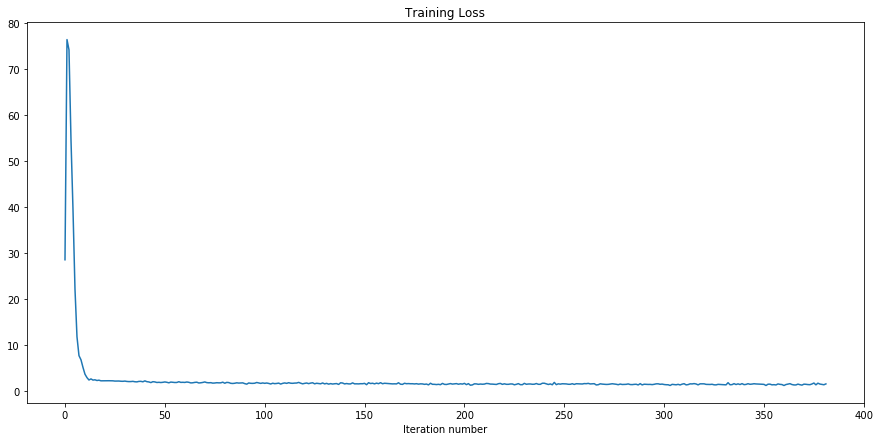

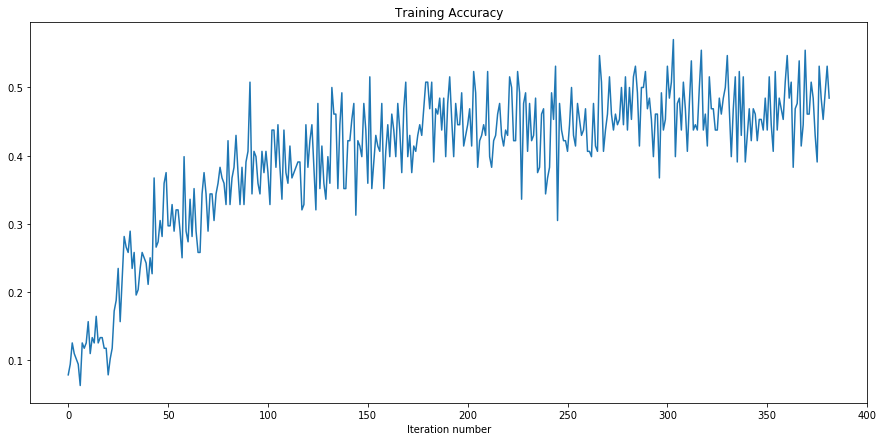

validation for epoch 0
-  epoch 0: validation accuracy = 0.496
train for epoch 1
iteration (400): loss = 1.272, accuracy = 0.547
iteration (450): loss = 1.408, accuracy = 0.477
iteration (500): loss = 1.413, accuracy = 0.508
iteration (550): loss = 1.142, accuracy = 0.609
iteration (600): loss = 1.338, accuracy = 0.469
iteration (650): loss = 1.393, accuracy = 0.516
iteration (700): loss = 1.364, accuracy = 0.562
iteration (750): loss = 1.263, accuracy = 0.586


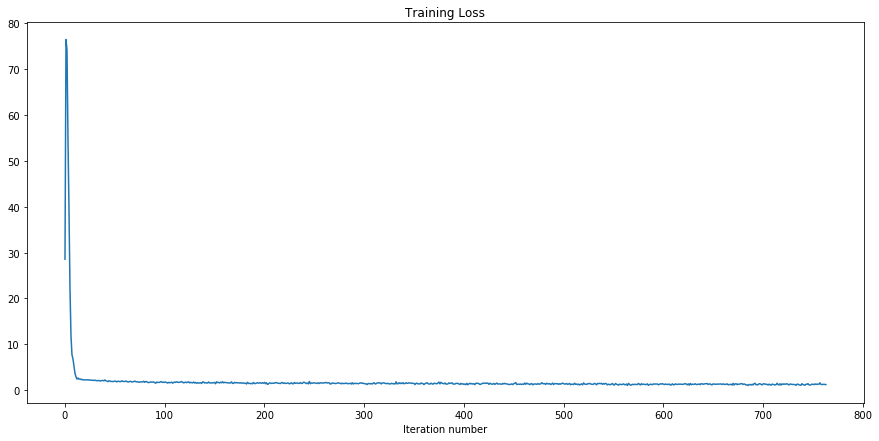

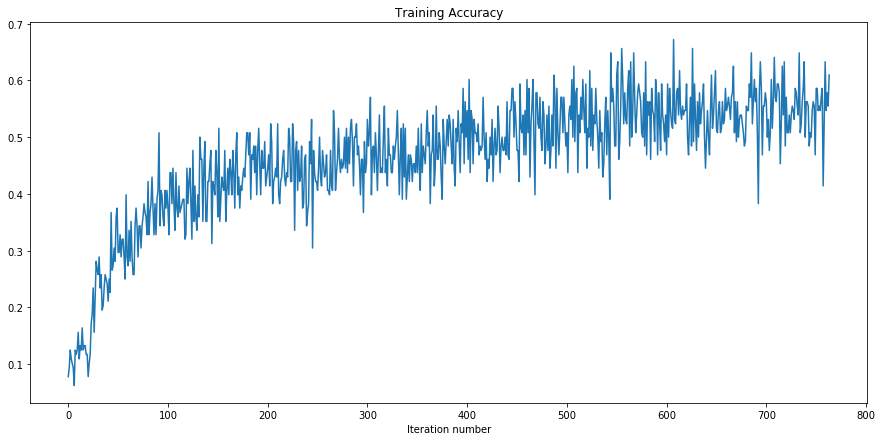

validation for epoch 1
-  epoch 1: validation accuracy = 0.567
train for epoch 2
iteration (800): loss = 1.221, accuracy = 0.547
iteration (850): loss = 1.286, accuracy = 0.547
iteration (900): loss = 1.206, accuracy = 0.562
iteration (950): loss = 1.008, accuracy = 0.625
iteration (1000): loss = 1.075, accuracy = 0.641
iteration (1050): loss = 1.180, accuracy = 0.594
iteration (1100): loss = 0.966, accuracy = 0.664


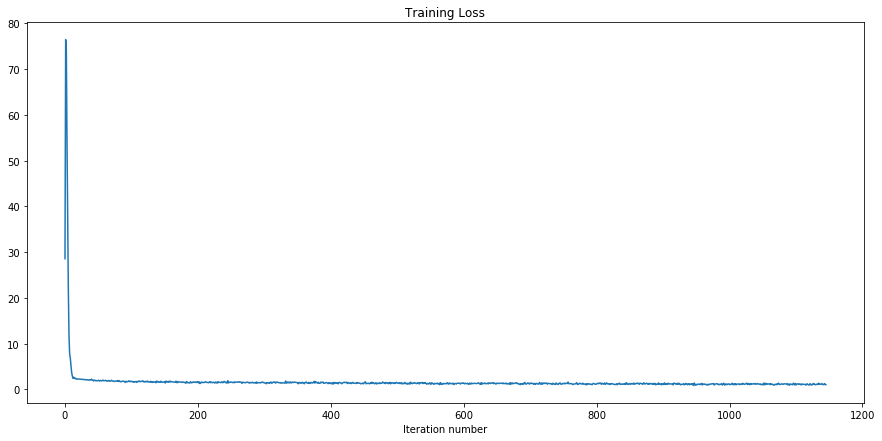

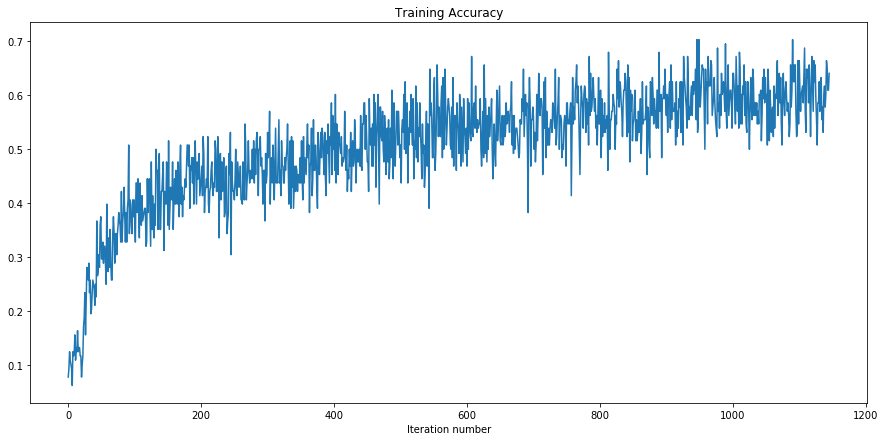

validation for epoch 2
-  epoch 2: validation accuracy = 0.578
train for epoch 3
iteration (1150): loss = 1.108, accuracy = 0.609
iteration (1200): loss = 0.884, accuracy = 0.688
iteration (1250): loss = 1.141, accuracy = 0.602
iteration (1300): loss = 1.150, accuracy = 0.586
iteration (1350): loss = 0.978, accuracy = 0.656
iteration (1400): loss = 0.982, accuracy = 0.711
iteration (1450): loss = 0.988, accuracy = 0.633
iteration (1500): loss = 0.964, accuracy = 0.641


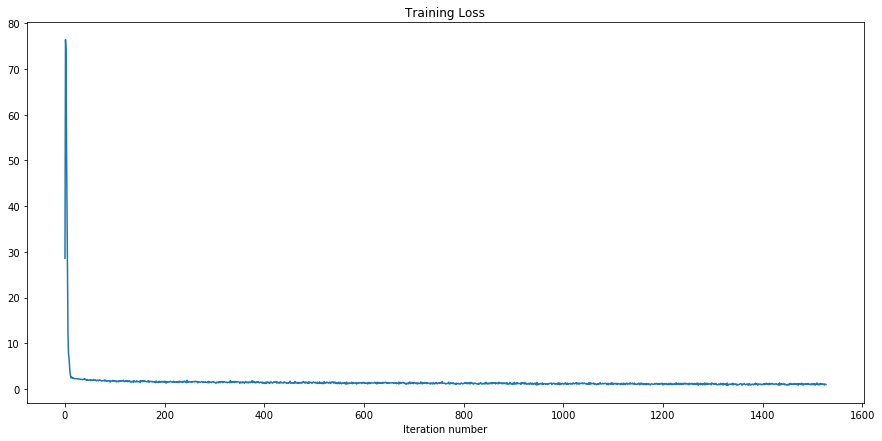

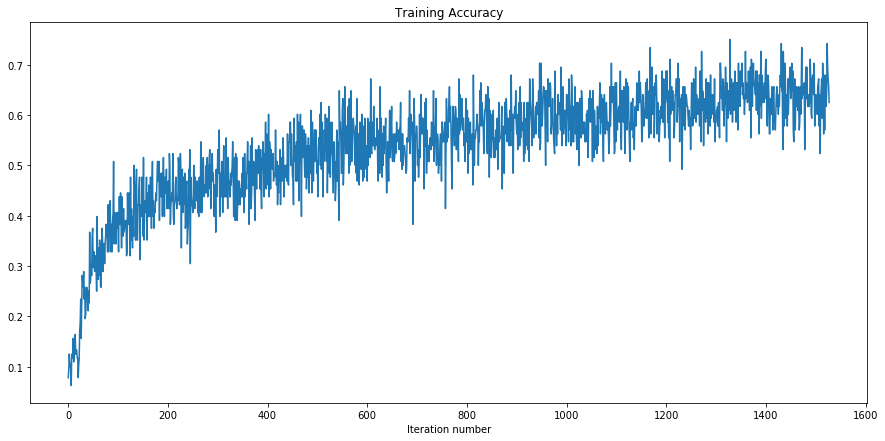

validation for epoch 3
-  epoch 3: validation accuracy = 0.603
train for epoch 4
iteration (1550): loss = 0.950, accuracy = 0.719
iteration (1600): loss = 0.913, accuracy = 0.641
iteration (1650): loss = 0.873, accuracy = 0.680
iteration (1700): loss = 1.049, accuracy = 0.609
iteration (1750): loss = 0.995, accuracy = 0.617
iteration (1800): loss = 1.012, accuracy = 0.641
iteration (1850): loss = 0.904, accuracy = 0.648
iteration (1900): loss = 0.923, accuracy = 0.664


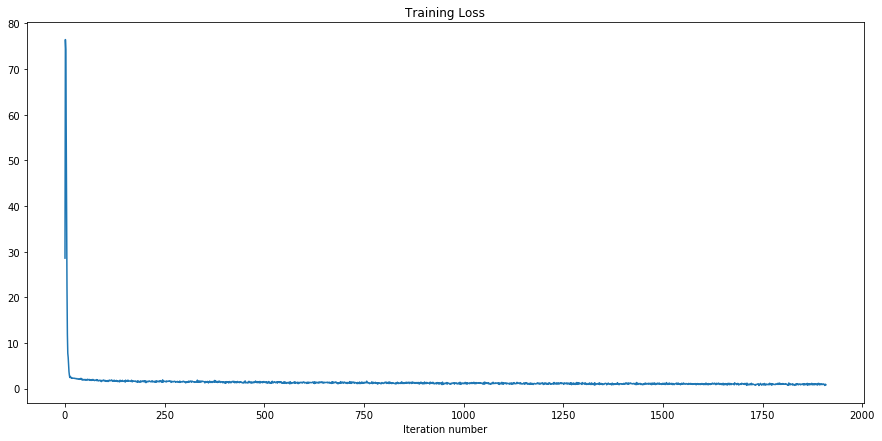

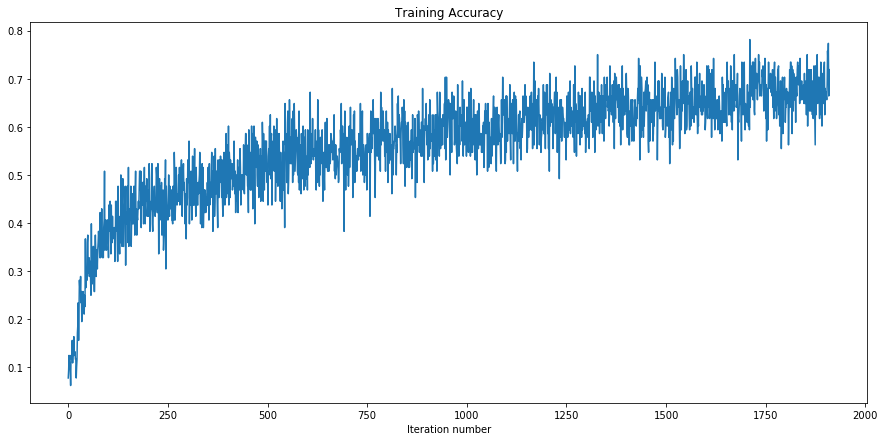

validation for epoch 4
-  epoch 4: validation accuracy = 0.623
***** test accuracy: 0.601
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [60]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [61]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10


    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################

        print('intput layer: ' + str(self.X.get_shape()))
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.batchnorm1 = normalize(self.conv1, 32, self.is_train)
            self.relu1 = tf.nn.relu(self.batchnorm1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.batchnorm2 = normalize(self.conv2, 64, self.is_train)
            self.relu2 = tf.nn.relu(self.batchnorm2)
            self.pool2 = max_pool(self.relu2, 3, 2)              
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2, 3, 1, 128)
            self.relu3 = tf.nn.relu(self.conv3)
            self.pool3 = max_pool(self.relu3, 3, 2)              
            print('conv3 layer: ' + str(self.pool3.get_shape()))

        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.pool3, 1, 1, 128)
            self.relu4 = tf.nn.relu(self.conv4)
            print('conv4 layer: ' + str(self.relu4.get_shape()))

        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.relu4, 1, 1, 128)
            self.relu5 = tf.nn.relu(self.conv5)
            print('conv5 layer: ' + str(self.relu5.get_shape()))


        self.flat = flatten(self.relu5)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = fully_conn(self.flat,384)
            print('fc3 layer: ' + str(self.fc3.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = fully_conn(self.fc3,10)            
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])        
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)

    def _build_optimizer(self):
        g_step = tf.Variable(0, trainable=False)
        learning_rate_initial = 5e-4
        learning_rate = tf.train.exponential_decay(learning_rate_initial, g_step,
                                           500, 0.96, staircase=True)
        
        self.train_op = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=g_step))
        
    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits = logits, dim = -1))        

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        keep_prob = 0.0
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                keep_prob = 0.75
                feed_dict = {self.X: X_,
                            self.Y: Y_, self.is_train: True}                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                
                
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
            
            plt.plot(losses)
            plt.title('Training Loss')
            plt.xlabel('Iteration number')
            plt.gcf().set_size_inches(15, 7)
            plt.show()

            plt.plot(accuracies)
            plt.title('Training Accuracy')
            plt.xlabel('Iteration number')
            plt.gcf().set_size_inches(15, 7)
            plt.show()
            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]                        
            feed_dict = {self.X:X_, self.Y:Y_, self.is_train: False}
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
conv4 layer: (?, 4, 4, 128)
conv5 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.306, accuracy = 0.055
iteration (50): loss = 1.649, accuracy = 0.359
iteration (100): loss = 1.505, accuracy = 0.438
iteration (150): loss = 1.475, accuracy = 0.398
iteration (200): loss = 1.476, accuracy = 0.453
iteration (250): loss = 1.371, accuracy = 0.516
iteration (300): loss = 1.148, accuracy = 0.602
iteration (350): loss = 1.363, accuracy = 0.453


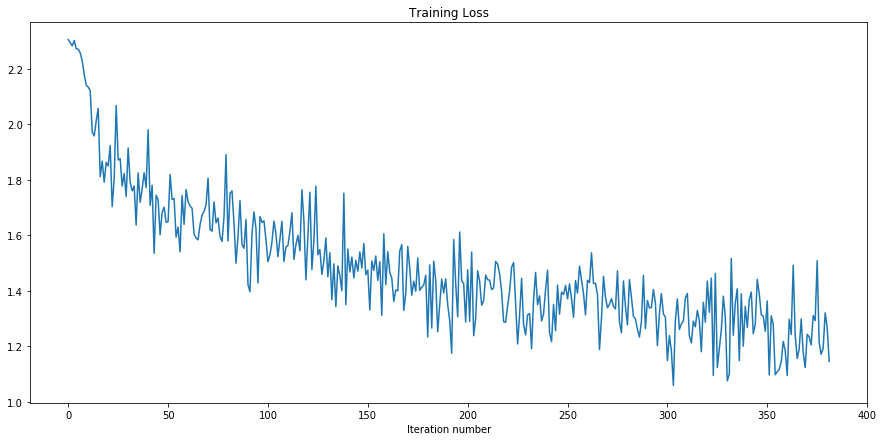

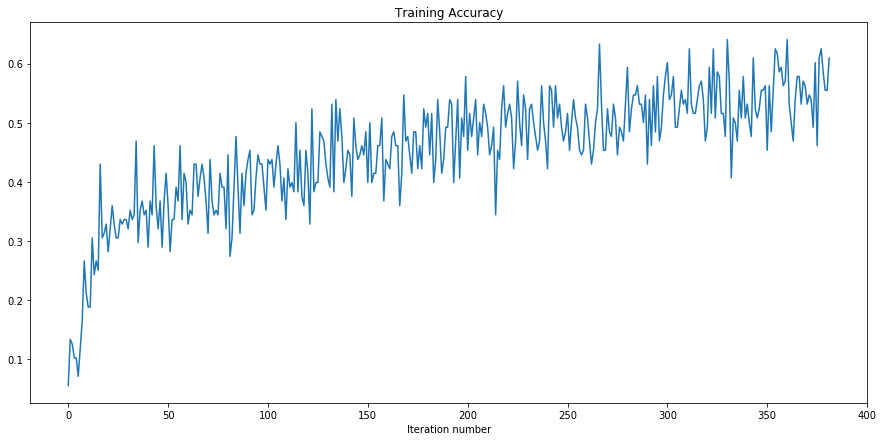

validation for epoch 0
-  epoch 0: validation accuracy = 0.519
train for epoch 1
iteration (400): loss = 1.214, accuracy = 0.516
iteration (450): loss = 1.257, accuracy = 0.539
iteration (500): loss = 1.206, accuracy = 0.562
iteration (550): loss = 1.042, accuracy = 0.672
iteration (600): loss = 0.964, accuracy = 0.664
iteration (650): loss = 1.300, accuracy = 0.516
iteration (700): loss = 1.194, accuracy = 0.625
iteration (750): loss = 0.902, accuracy = 0.680


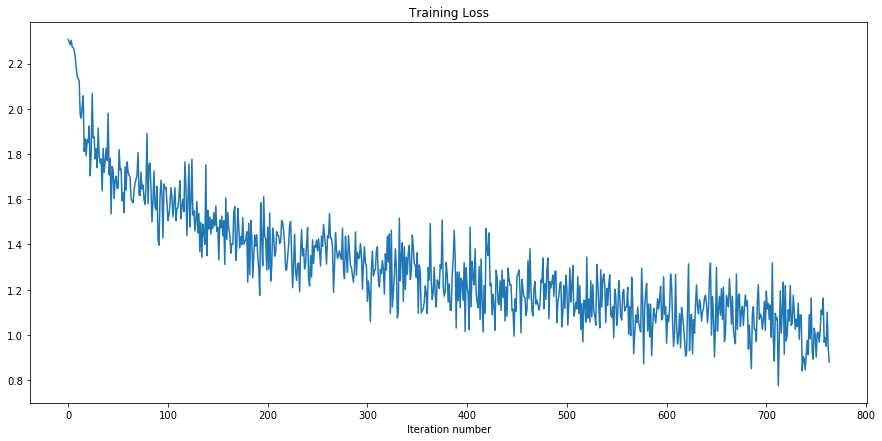

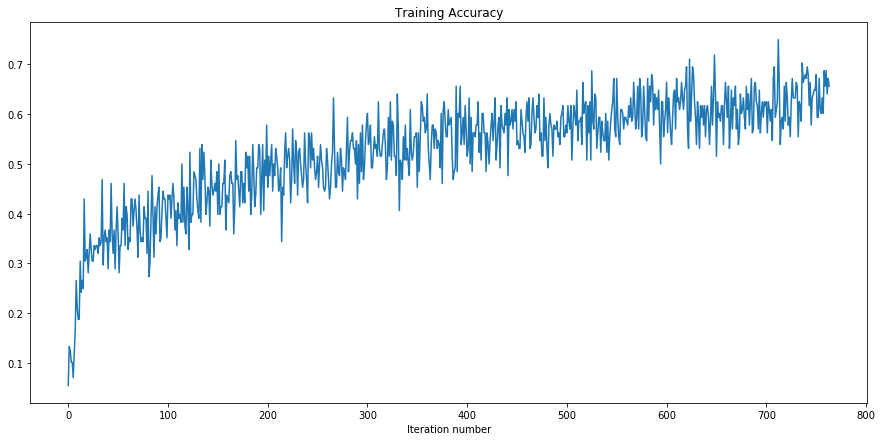

validation for epoch 1
-  epoch 1: validation accuracy = 0.541
train for epoch 2
iteration (800): loss = 0.951, accuracy = 0.656
iteration (850): loss = 1.046, accuracy = 0.680
iteration (900): loss = 0.977, accuracy = 0.656
iteration (950): loss = 0.824, accuracy = 0.695
iteration (1000): loss = 0.756, accuracy = 0.719
iteration (1050): loss = 0.860, accuracy = 0.773
iteration (1100): loss = 0.748, accuracy = 0.672


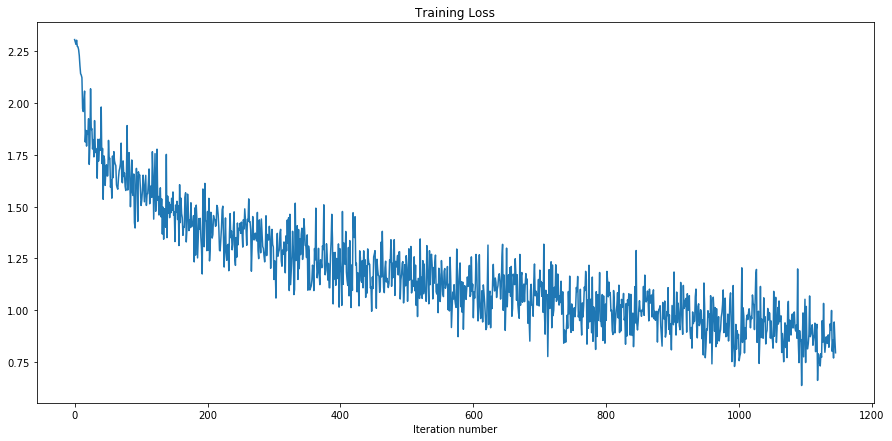

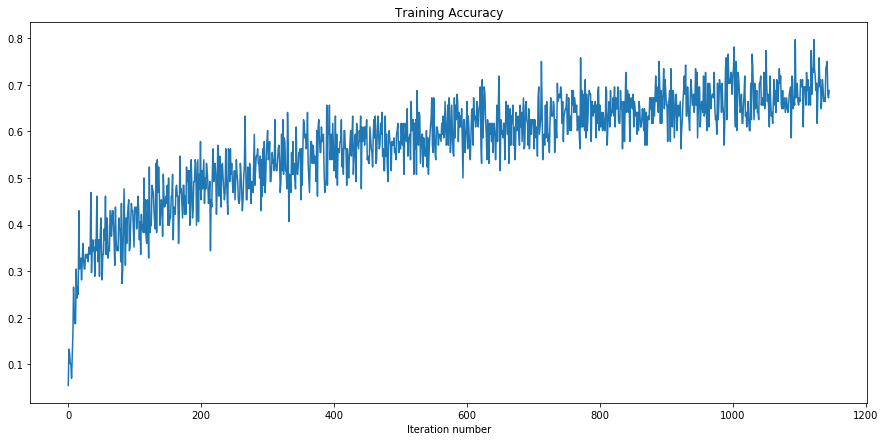

validation for epoch 2
-  epoch 2: validation accuracy = 0.657
train for epoch 3
iteration (1150): loss = 0.919, accuracy = 0.688
iteration (1200): loss = 0.816, accuracy = 0.688
iteration (1250): loss = 0.880, accuracy = 0.703
iteration (1300): loss = 0.925, accuracy = 0.680
iteration (1350): loss = 0.766, accuracy = 0.734
iteration (1400): loss = 0.863, accuracy = 0.758
iteration (1450): loss = 0.750, accuracy = 0.734
iteration (1500): loss = 0.593, accuracy = 0.828


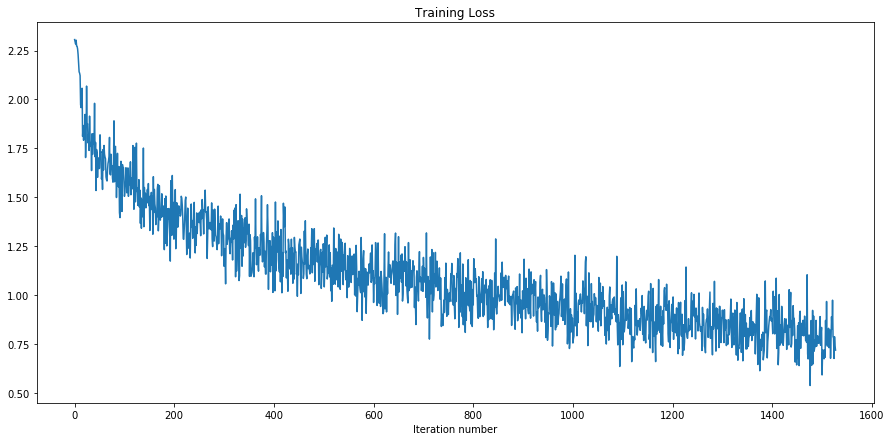

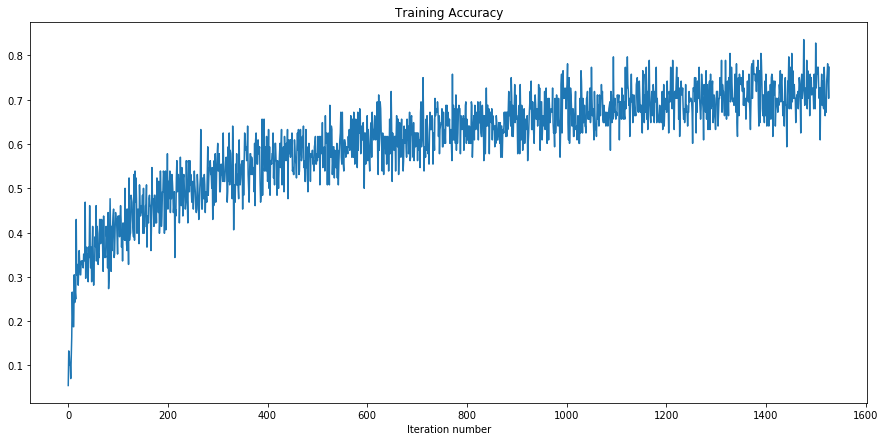

validation for epoch 3
-  epoch 3: validation accuracy = 0.692
train for epoch 4
iteration (1550): loss = 0.692, accuracy = 0.758
iteration (1600): loss = 0.778, accuracy = 0.734
iteration (1650): loss = 0.815, accuracy = 0.711
iteration (1700): loss = 0.731, accuracy = 0.734
iteration (1750): loss = 0.767, accuracy = 0.734
iteration (1800): loss = 0.625, accuracy = 0.789
iteration (1850): loss = 0.697, accuracy = 0.750
iteration (1900): loss = 0.763, accuracy = 0.758


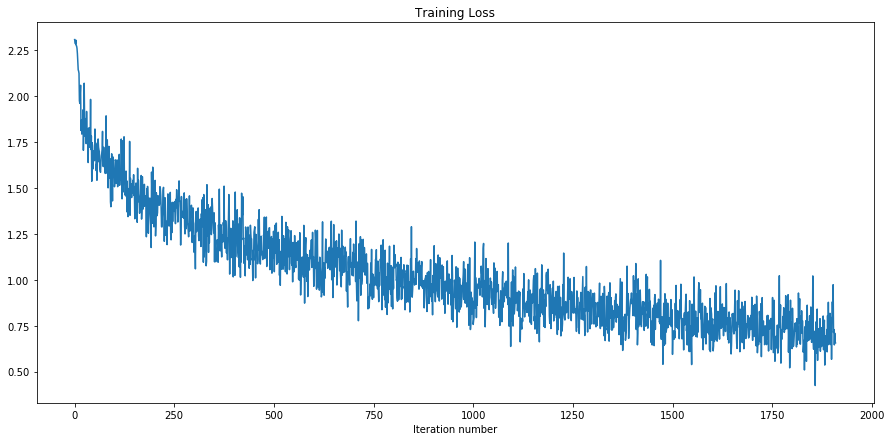

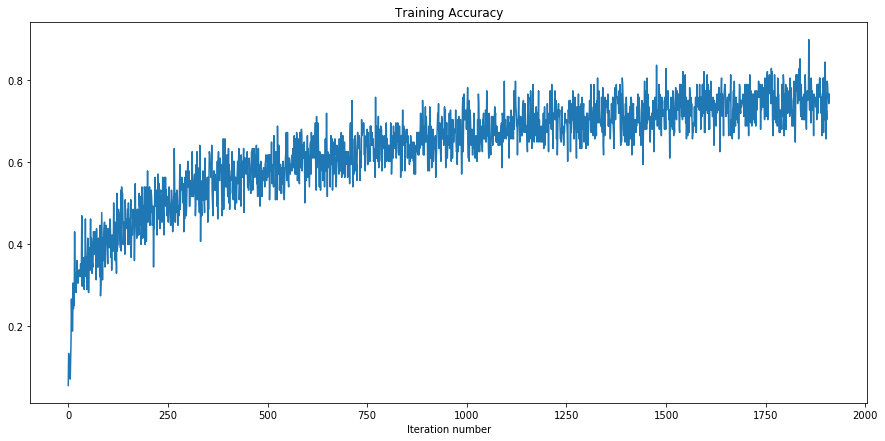

validation for epoch 4
-  epoch 4: validation accuracy = 0.720
train for epoch 5
iteration (1950): loss = 0.769, accuracy = 0.703
iteration (2000): loss = 0.618, accuracy = 0.773
iteration (2050): loss = 0.717, accuracy = 0.719
iteration (2100): loss = 0.762, accuracy = 0.727
iteration (2150): loss = 0.919, accuracy = 0.688
iteration (2200): loss = 0.701, accuracy = 0.758
iteration (2250): loss = 0.584, accuracy = 0.750


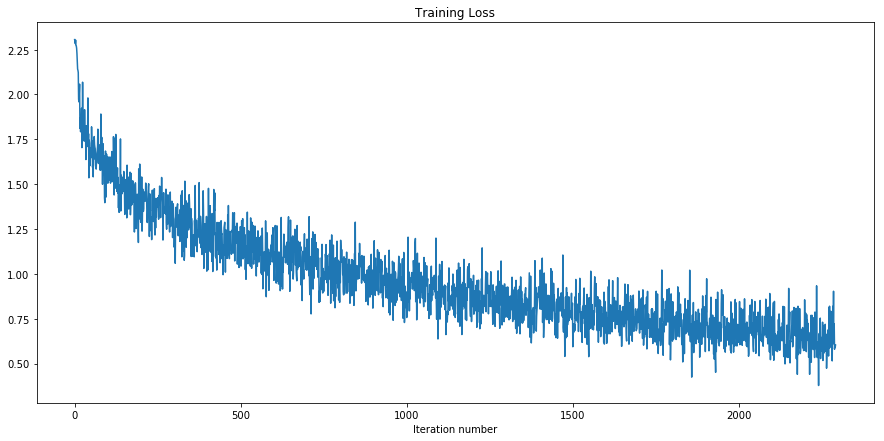

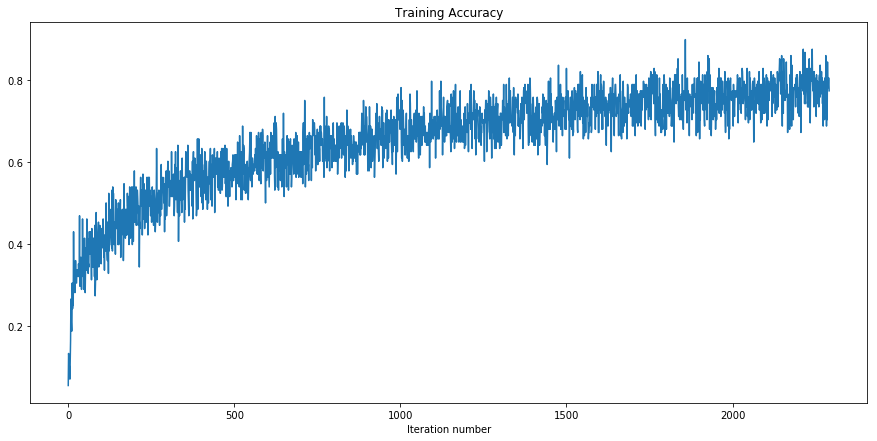

validation for epoch 5
-  epoch 5: validation accuracy = 0.739
train for epoch 6
iteration (2300): loss = 0.642, accuracy = 0.797
iteration (2350): loss = 0.670, accuracy = 0.750
iteration (2400): loss = 0.611, accuracy = 0.805
iteration (2450): loss = 0.597, accuracy = 0.781
iteration (2500): loss = 0.563, accuracy = 0.812
iteration (2550): loss = 0.646, accuracy = 0.773
iteration (2600): loss = 0.495, accuracy = 0.867
iteration (2650): loss = 0.541, accuracy = 0.812


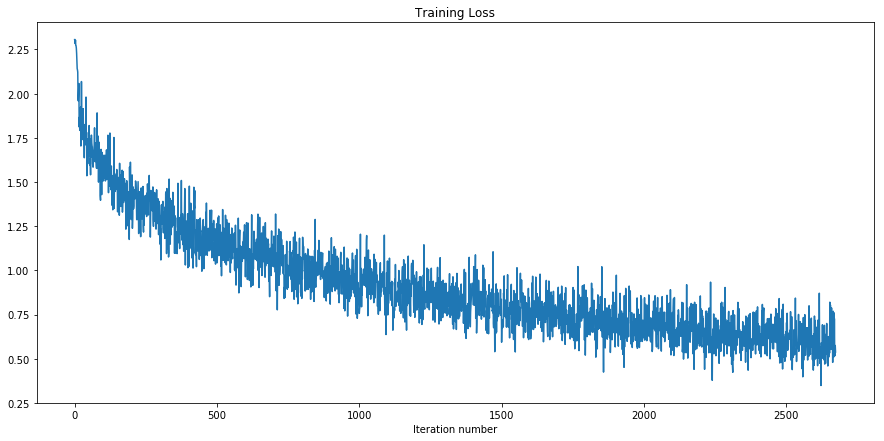

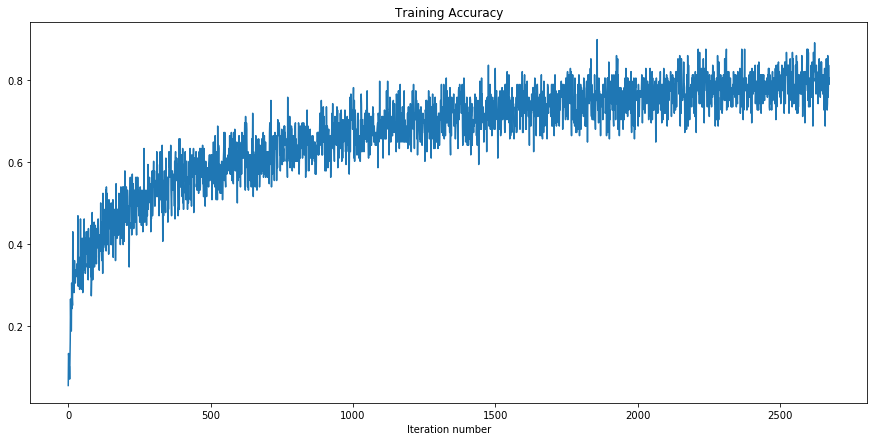

validation for epoch 6
-  epoch 6: validation accuracy = 0.725
train for epoch 7
iteration (2700): loss = 0.657, accuracy = 0.750
iteration (2750): loss = 0.637, accuracy = 0.750
iteration (2800): loss = 0.523, accuracy = 0.805
iteration (2850): loss = 0.518, accuracy = 0.773
iteration (2900): loss = 0.496, accuracy = 0.844
iteration (2950): loss = 0.495, accuracy = 0.797
iteration (3000): loss = 0.454, accuracy = 0.859
iteration (3050): loss = 0.511, accuracy = 0.820


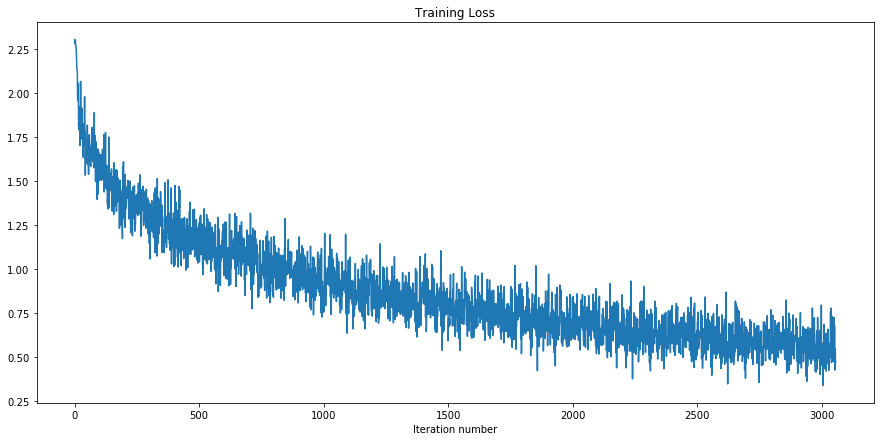

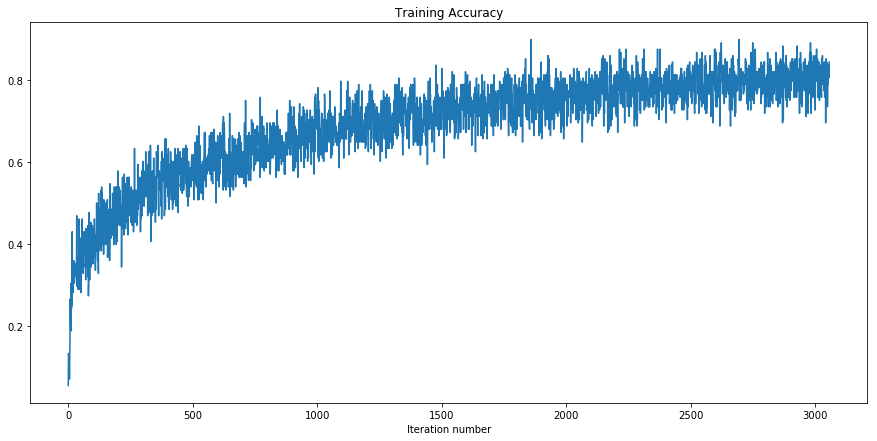

validation for epoch 7
-  epoch 7: validation accuracy = 0.712
train for epoch 8
iteration (3100): loss = 0.495, accuracy = 0.828
iteration (3150): loss = 0.572, accuracy = 0.828
iteration (3200): loss = 0.648, accuracy = 0.750
iteration (3250): loss = 0.713, accuracy = 0.719
iteration (3300): loss = 0.400, accuracy = 0.859
iteration (3350): loss = 0.600, accuracy = 0.773
iteration (3400): loss = 0.511, accuracy = 0.828


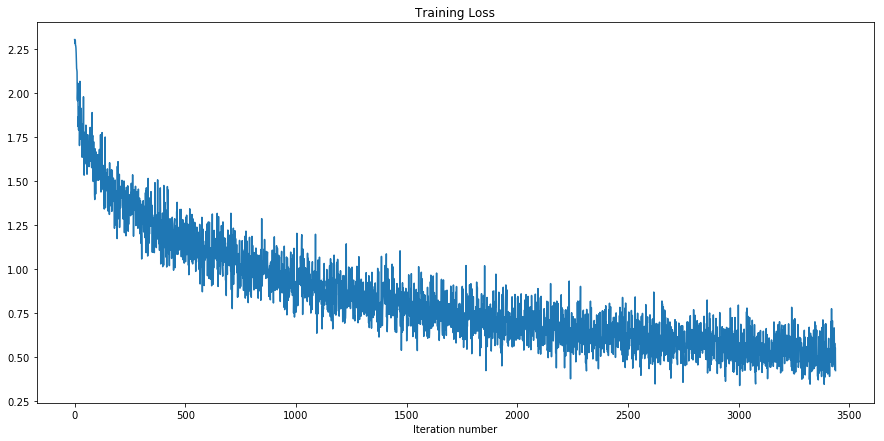

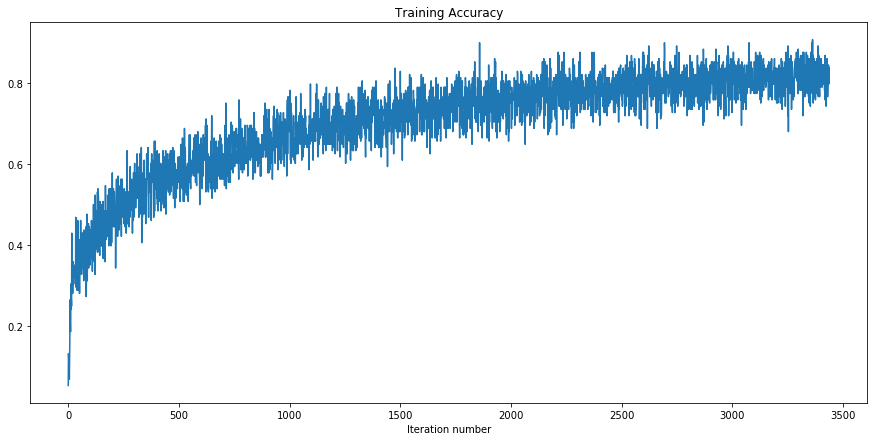

validation for epoch 8
-  epoch 8: validation accuracy = 0.721
train for epoch 9
iteration (3450): loss = 0.486, accuracy = 0.820
iteration (3500): loss = 0.501, accuracy = 0.805
iteration (3550): loss = 0.539, accuracy = 0.820
iteration (3600): loss = 0.439, accuracy = 0.836
iteration (3650): loss = 0.529, accuracy = 0.812
iteration (3700): loss = 0.607, accuracy = 0.750
iteration (3750): loss = 0.520, accuracy = 0.820
iteration (3800): loss = 0.473, accuracy = 0.828


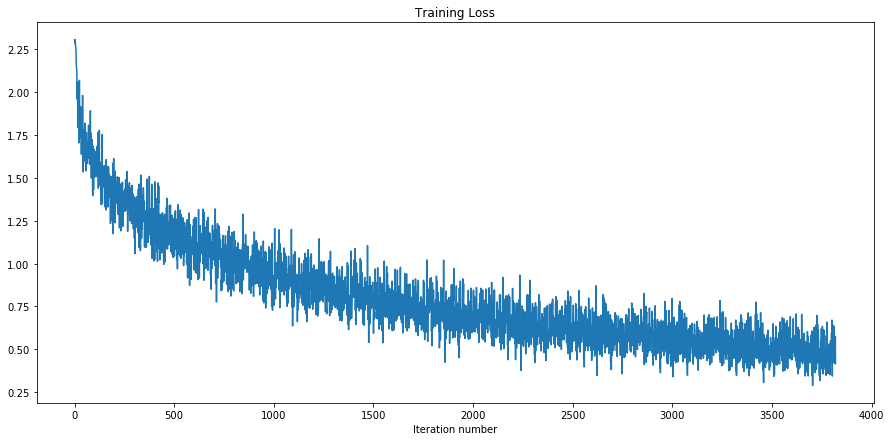

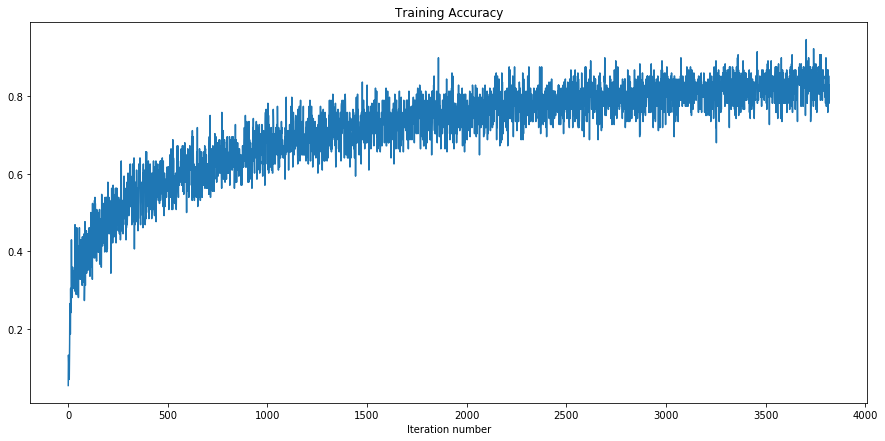

validation for epoch 9
-  epoch 9: validation accuracy = 0.719
***** test accuracy: 0.701
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [62]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = X_train
X_val_ = X_val
X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [63]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
conv4 layer: (?, 4, 4, 128)
conv5 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
